In [58]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

root = Path("unified")

# Dizionario dove salviamo tutti i dataset
all_datasets = {}

for csv_file in root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name  # nome della cartella esperimento
    df = pd.read_csv(csv_file)
    df["source"] = experiment_name.upper()  # aggiungiamo la colonna "source"
    all_datasets[experiment_name] = df
    print(f"Caricato cutomers {experiment_name} experiment ({len(df)} righe)")

# Se vuoi un unico DataFrame con tutto insieme
df_all = pd.concat(all_datasets.values(), ignore_index=True)

Caricato cutomers net_loss experiment (485 righe)
Caricato cutomers mem_stress experiment (486 righe)
Caricato cutomers IO pressure experiment (481 righe)
Caricato cutomers baseline experiment (492 righe)
Caricato cutomers cpu_stress experiment (484 righe)


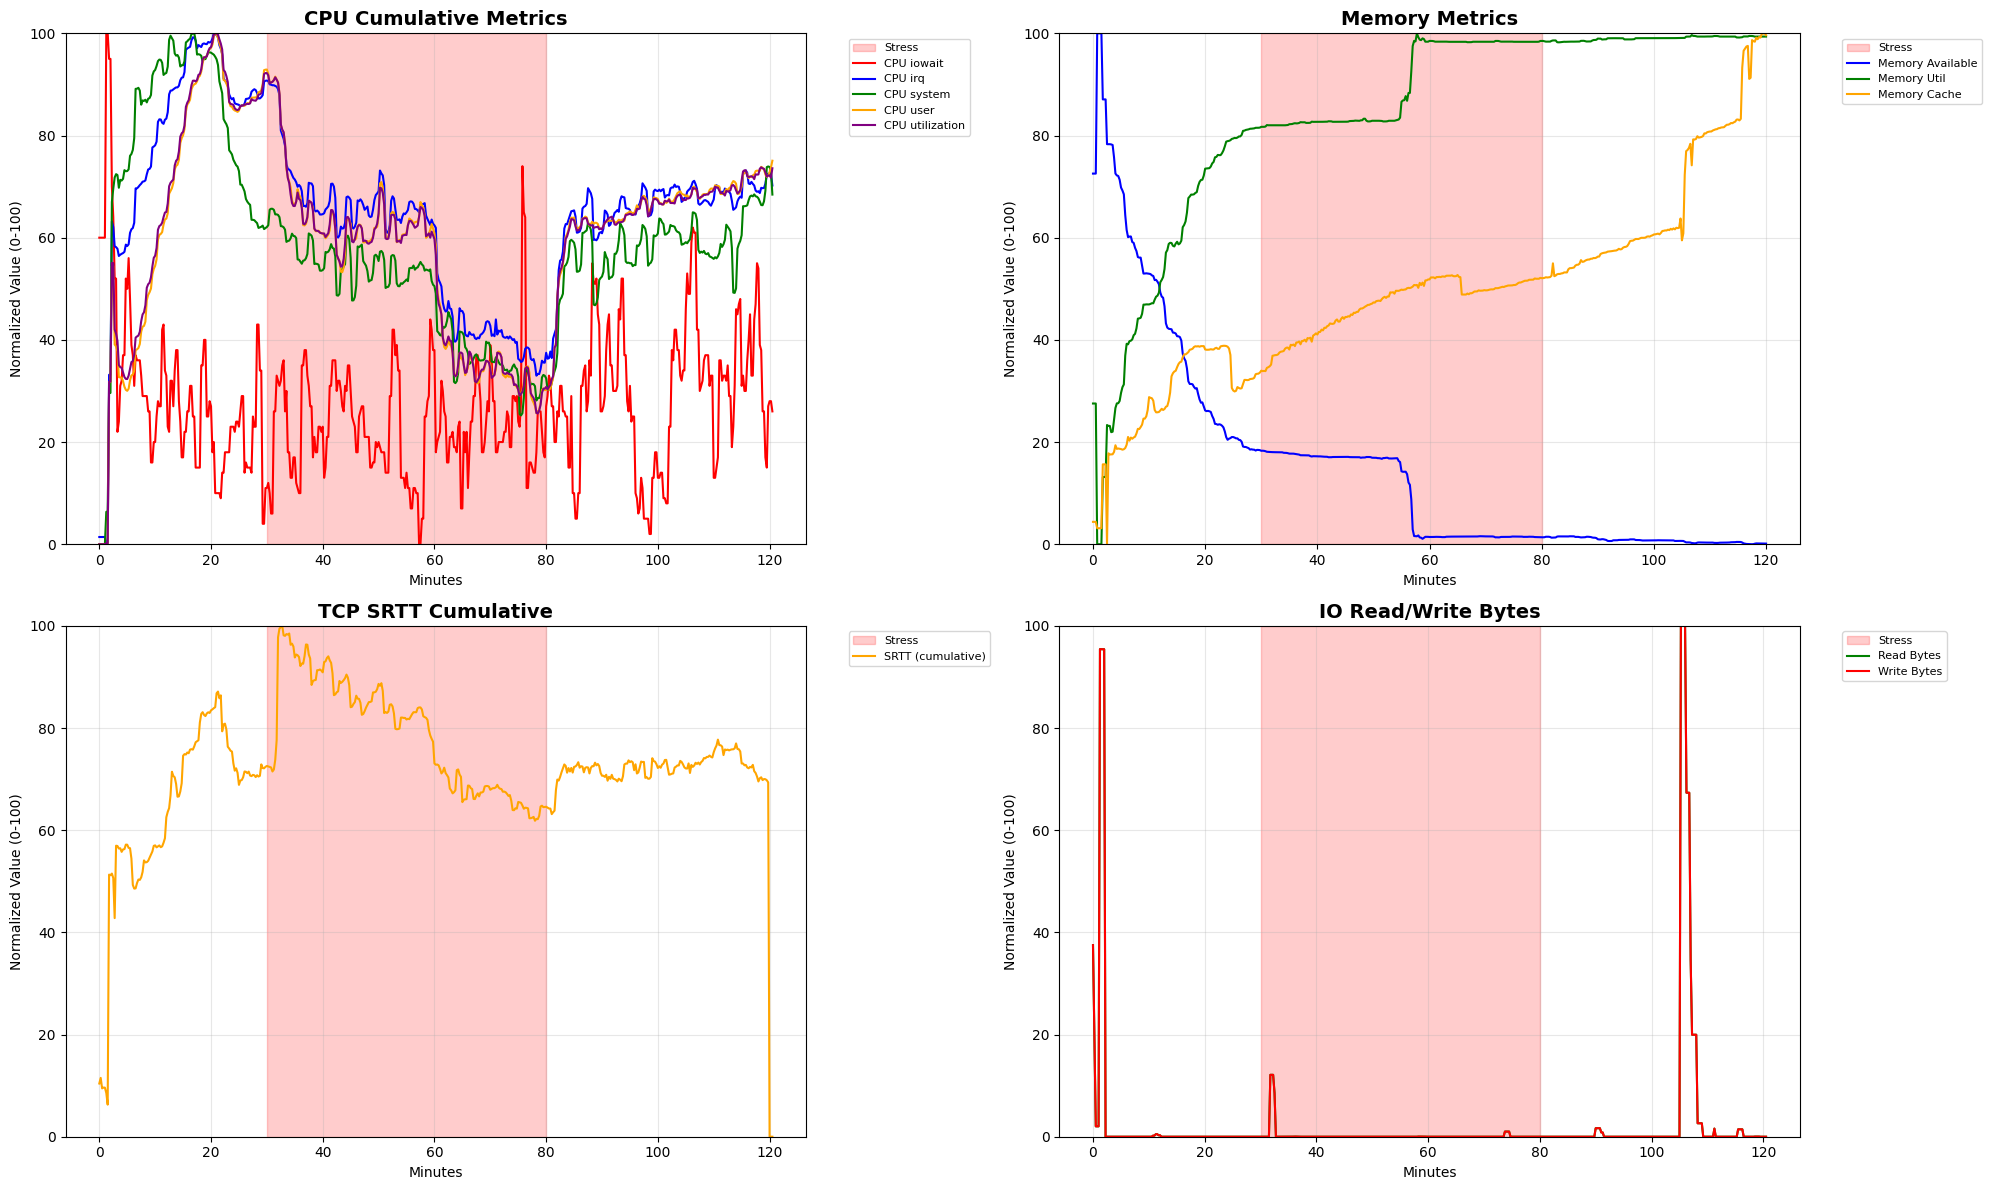

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def normalize_0_100(series: pd.Series) -> pd.Series:
    """Normalizza una serie tra 0 e 100"""
    min_val = series.min()
    max_val = series.max()
    if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
        return pd.Series([0] * len(series), index=series.index)
    return (series - min_val) / (max_val - min_val) * 100

def calculate_cpu_cumulative(df: pd.DataFrame, metric_type: str):
    """Calcola il cumulativo di una specifica metrica CPU attraverso tutti i core"""
    cpu_cols = [col for col in df.columns if metric_type.lower() in col.lower() 
                and 'cpu' in col.lower() and 'minutes' not in col.lower()]
    
    if not cpu_cols:
        return None
    
    return df[cpu_cols].sum(axis=1)

def calculate_srtt_cumulative(df: pd.DataFrame):
    """Calcola il cumulativo SRTT"""
    srtt_cols = [col for col in df.columns if 'srtt' in col.lower() 
                 and 'minutes' not in col.lower()]
    
    if not srtt_cols:
        return None
    
    return df[srtt_cols].sum(axis=1)

def plot_cpu_cumulative_thin(df: pd.DataFrame, time_col='minutes'):
    """Plot CPU cumulative con linee sottili"""
    if time_col not in df.columns:
        print(f"Attenzione: colonna '{time_col}' non trovata nel DataFrame")
        return
    
    cpu_metrics = ['iowait', 'irq', 'system', 'user', 'utilization']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    plt.figure(figsize=(14, 8))
    
    # Aggiungi span per periodo di stress
    plt.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    for i, metric in enumerate(cpu_metrics):
        cumulative = calculate_cpu_cumulative(df, metric)
        if cumulative is not None:
            normalized_cumulative = normalize_0_100(cumulative)
            plt.plot(df[time_col], normalized_cumulative, 
                    label=f'CPU {metric} (cumulativo)', 
                    linewidth=1.5,  # Linee più sottili
                    color=colors[i % len(colors)])
    
    plt.title("Metriche CPU Cumulative - Normalizzate (0-100)", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Tempo (minuti)", fontsize=12)
    plt.ylabel("Valore normalizzato (0-100)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_memory_metrics(df: pd.DataFrame, time_col='minutes'):
    """Plot metriche Memory: mem_available, mem_util, mem_cache"""
    if time_col not in df.columns:
        print(f"Attenzione: colonna '{time_col}' non trovata nel DataFrame")
        return
    
    # Cerca le colonne memory specifiche
    mem_available = [col for col in df.columns if 'memavailable' in col.lower() 
                     and 'minutes' not in col.lower()]
    mem_util = [col for col in df.columns if 'memutil' in col.lower() 
                and 'minutes' not in col.lower()]
    mem_cache = [col for col in df.columns if 'memcache' in col.lower() 
                 and 'minutes' not in col.lower()]
    
    plt.figure(figsize=(9,5))
    
    # Aggiungi span per periodo di stress
    plt.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    colors = ['blue', 'green', 'orange']
    labels = ['Memory Available', 'Memory Util', 'Memory Cache']
    metric_groups = [mem_available, mem_util, mem_cache]
    
    for i, (metrics, label, color) in enumerate(zip(metric_groups, labels, colors)):
        for col in metrics:
            if col in df.columns:
                normalized_series = normalize_0_100(df[col])
                plt.plot(df[time_col], normalized_series, 
                        label=label, 
                        linewidth=1.5,
                        color=color)
                break  # Prendi solo la prima colonna trovata per ogni tipo
    
    plt.title("Metriche Memory - Normalizzate (0-100)", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Tempo (minuti)", fontsize=12)
    plt.ylabel("Valore normalizzato (0-100)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_tcp_srtt_cumulative(df: pd.DataFrame, time_col='minutes'):
    """Plot TCP: solo SRTT cumulativo"""
    if time_col not in df.columns:
        print(f"Attenzione: colonna '{time_col}' non trovata nel DataFrame")
        return
    
    srtt_cumulative = calculate_srtt_cumulative(df)
    
    if srtt_cumulative is None:
        print("Nessuna metrica SRTT trovata")
        return
    
    plt.figure(figsize=(9,5))
    
    # Aggiungi span per periodo di stress
    plt.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    normalized_srtt = normalize_0_100(srtt_cumulative)
    plt.plot(df[time_col], normalized_srtt, 
            label='SRTT (cumulativo)', 
            linewidth=1.5,
            color='orange')
    
    plt.title("Metrica TCP SRTT Cumulativa - Normalizzata (0-100)", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Tempo (minuti)", fontsize=12)
    plt.ylabel("Valore normalizzato (0-100)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_io_readwrite(df: pd.DataFrame, time_col='minutes'):
    """Plot IO: readbytes e writebytes insieme"""
    if time_col not in df.columns:
        print(f"Attenzione: colonna '{time_col}' non trovata nel DataFrame")
        return
    
    # Trova colonne readbytes e writebytes
    read_cols = [col for col in df.columns if 'readbytes' in col.lower() 
                 and 'minutes' not in col.lower()]
    write_cols = [col for col in df.columns if 'writebytes' in col.lower() 
                  and 'minutes' not in col.lower()]
    
    if not read_cols and not write_cols:
        print("Nessuna metrica readbytes/writebytes trovata")
        return
    
    plt.figure(figsize=(9,5))
    
    plt.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    if read_cols:
        read_cumulative = df[read_cols].sum(axis=1)
        normalized_read = normalize_0_100(read_cumulative)
        plt.plot(df[time_col], normalized_read, 
                label='Read Bytes (cumulativo)', 
                linewidth=1.5,
                color='green')
    
    if write_cols:
        write_cumulative = df[write_cols].sum(axis=1)
        normalized_write = normalize_0_100(write_cumulative)
        plt.plot(df[time_col], normalized_write, 
                label='Write Bytes (cumulativo)', 
                linewidth=1.5,
                color='red')
    
    plt.title("Metriche IO - Read/Write Bytes Cumulative - Normalizzate (0-100)", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Tempo (minuti)", fontsize=12)
    plt.ylabel("Valore normalizzato (0-100)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_all_simplified_metrics_dashboard(df: pd.DataFrame, time_col='minutes'):
    """Plot tutti i 4 grafici in una dashboard 2x2"""
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # CPU Plot 
    ax1 = axes[0, 0]
    ax1.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    cpu_metrics = ['iowait', 'irq', 'system', 'user', 'utilization']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, metric in enumerate(cpu_metrics):
        cumulative = calculate_cpu_cumulative(df, metric)
        if cumulative is not None:
            normalized_cumulative = normalize_0_100(cumulative)
            ax1.plot(df[time_col], normalized_cumulative, 
                    label=f'CPU {metric}', 
                    linewidth=1.5,
                    color=colors[i % len(colors)])
    
    ax1.set_title("CPU Cumulative Metrics", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Minutes", fontsize=10)
    ax1.set_ylabel("Normalized Value (0-100)", fontsize=10)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)
    
    # Memory Plot
    ax2 = axes[0, 1]
    ax2.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    mem_available = [col for col in df.columns if 'memavailable' in col.lower() 
                     and 'minutes' not in col.lower()]
    mem_util = [col for col in df.columns if 'memutil' in col.lower() 
                and 'minutes' not in col.lower()]
    mem_cache = [col for col in df.columns if 'memcache' in col.lower() 
                 and 'minutes' not in col.lower()]
    
    colors = ['blue', 'green', 'orange']
    labels = ['Memory Available', 'Memory Util', 'Memory Cache']
    metric_groups = [mem_available, mem_util, mem_cache]
    
    for i, (metrics, label, color) in enumerate(zip(metric_groups, labels, colors)):
        for col in metrics:
            if col in df.columns:
                normalized_series = normalize_0_100(df[col])
                ax2.plot(df[time_col], normalized_series, 
                        label=label, 
                        linewidth=1.5,
                        color=color)
                break
    
    ax2.set_title("Memory Metrics", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Minutes", fontsize=10)
    ax2.set_ylabel("Normalized Value (0-100)", fontsize=10)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # TCP SRTT Plot 
    ax3 = axes[1, 0]
    ax3.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    srtt_cumulative = calculate_srtt_cumulative(df)
    if srtt_cumulative is not None:
        normalized_srtt = normalize_0_100(srtt_cumulative)
        ax3.plot(df[time_col], normalized_srtt, 
                label='SRTT (cumulative)', 
                linewidth=1.5,
                color='orange')
    
    ax3.set_title("TCP SRTT Cumulative", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Minutes", fontsize=10)
    ax3.set_ylabel("Normalized Value (0-100)", fontsize=10)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 100)
    
    # IO Plot 
    ax4 = axes[1, 1]
    ax4.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    read_cols = [col for col in df.columns if 'readbytes' in col.lower() 
                 and 'minutes' not in col.lower()]
    write_cols = [col for col in df.columns if 'writebytes' in col.lower() 
                  and 'minutes' not in col.lower()]
    
    if read_cols:
        read_cumulative = df[read_cols].sum(axis=1)
        normalized_read = normalize_0_100(read_cumulative)
        ax4.plot(df[time_col], normalized_read, 
                label='Read Bytes', 
                linewidth=1.5,
                color='green')
    
    if write_cols:
        write_cumulative = df[write_cols].sum(axis=1)
        normalized_write = normalize_0_100(write_cumulative)
        ax4.plot(df[time_col], normalized_write, 
                label='Write Bytes', 
                linewidth=1.5,
                color='red')
    
    ax4.set_title("IO Read/Write Bytes", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Minutes", fontsize=10)
    ax4.set_ylabel("Normalized Value (0-100)", fontsize=10)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

# Esempi di utilizzo:
# Dashboard 2x2
plot_all_simplified_metrics_dashboard(all_datasets['net_loss'])

# Oppure grafici individuali:
# plot_cpu_cumulative_thin(all_datasets['baseline'])
# plot_memory_metrics(all_datasets['baseline'])
# plot_tcp_srtt_cumulative(all_datasets['baseline'])
# plot_io_readwrite(all_datasets['baseline'])

LSTM

Starting optimized training with all techniques...
=== OPTIMIZED FAILURE DETECTION TRAINING ===


🧪 TESTING CONFIGURATION: BASELINE
📊 Loading data with adaptive failure windows...
Loading net_loss...
  net_loss: 194/485 failures (40.0%)
Loading mem_stress...
  mem_stress: 195/486 failures (40.1%)
Loading IO pressure...
  IO pressure: 193/481 failures (40.1%)
Loading baseline...
  Baseline: all normal
Loading cpu_stress...
  cpu_stress: 193/484 failures (39.9%)
Using 83 features

Dataset: 2333 sequences, 775 failures
Splits: Train=1311, Val=328, Test=694

📊 Using standard BINARY CROSSENTROPY

🏋️ Training Baseline model...

🏋️ Training WITHOUT class weights
Epoch 1/25


/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7997 - loss: 0.4656 - val_accuracy: 0.5945 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9732 - loss: 0.1280 - val_accuracy: 0.6890 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9809 - loss: 0.0784 - val_accuracy: 0.7073 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9737 - loss: 0.0970 - val_accuracy: 0.7591 - val_loss: 0.5818 - learning_rate: 0.0010
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9919 - loss: 0.0364 - val_accuracy: 0.6738 - val_loss: 0.8980 - learning_rate: 0.0010
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9903 - loss: 0.0336 - val_accuracy: 0.8201 - val_loss: 0.4423 - learning_rate: 0.0010
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9902 - loss: 0.0398 - val_accuracy: 0.72

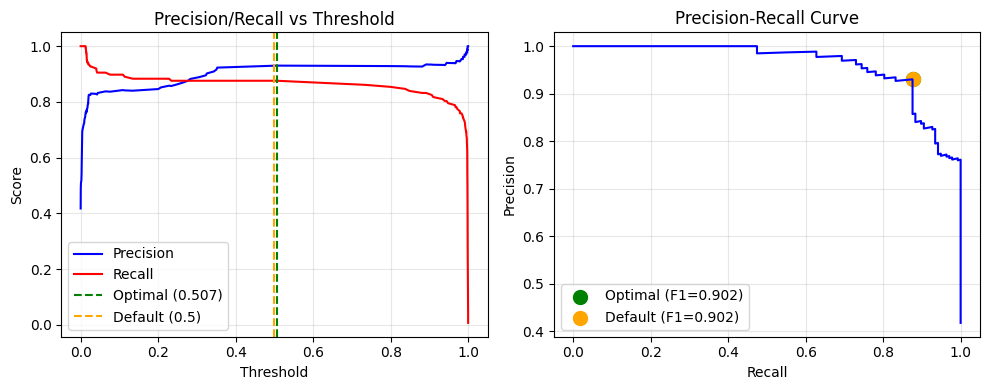


📊 EVALUATION WITH OPTIMAL THRESHOLD

🔄 COMPARISON: Default vs Optimal Threshold
--------------------------------------------------
Default (0.5):     Acc=0.793, Prec=0.989, Rec=0.378, F1=0.547
Optimal (0.507): Acc=0.793, Prec=0.989, Rec=0.378, F1=0.547

📈 IMPROVEMENTS:
   Accuracy:  +0.000
   Precision: +0.000
   Recall:    +0.000 ⭐
   F1-Score:  +0.000
   AUC:       0.739 (unchanged - depends on ranking)


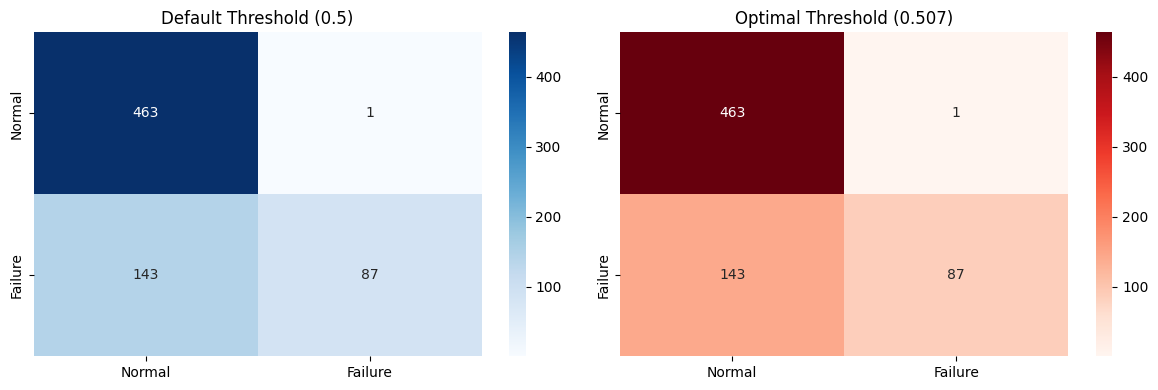

✅ Saved: optimized_detector_baseline.keras

🧪 TESTING CONFIGURATION: CLASS WEIGHTS ONLY

📊 Using standard BINARY CROSSENTROPY

🏋️ Training Class Weights Only model...

⚖️  CLASS WEIGHTS CALCULATED:
   Normal: 0.726
   Failure: 1.607
   Failure examples are weighted 2.2x more than normal
   This compensates for class imbalance

🏋️ Training with CLASS WEIGHTS
Epoch 1/25


/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7616 - loss: 0.5236 - val_accuracy: 0.7195 - val_loss: 0.6075 - learning_rate: 0.0010
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9515 - loss: 0.1756 - val_accuracy: 0.7500 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9761 - loss: 0.0778 - val_accuracy: 0.7988 - val_loss: 0.4684 - learning_rate: 0.0010
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9802 - loss: 0.0657 - val_accuracy: 0.7835 - val_loss: 0.5721 - learning_rate: 0.0010
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9789 - loss: 0.0643 - val_accuracy: 0.8963 - val_loss: 0.3629 - learning_rate: 0.0010
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9931 - loss: 0.0333 - val_accuracy: 0.7957 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9883 - loss: 0.0367 - val_accuracy: 0.79

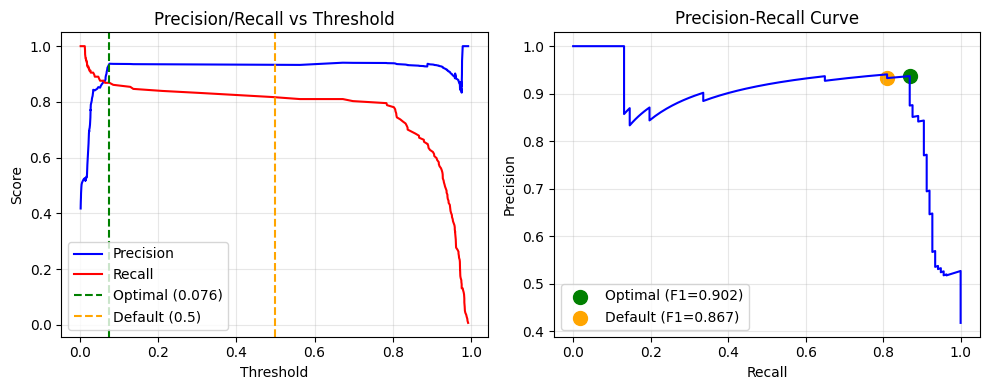


📊 EVALUATION WITH OPTIMAL THRESHOLD

🔄 COMPARISON: Default vs Optimal Threshold
--------------------------------------------------
Default (0.5):     Acc=0.755, Prec=1.000, Rec=0.261, F1=0.414
Optimal (0.076): Acc=0.831, Prec=1.000, Rec=0.491, F1=0.659

📈 IMPROVEMENTS:
   Accuracy:  +0.076
   Precision: +0.000
   Recall:    +0.230 ⭐
   F1-Score:  +0.245
   AUC:       0.888 (unchanged - depends on ranking)


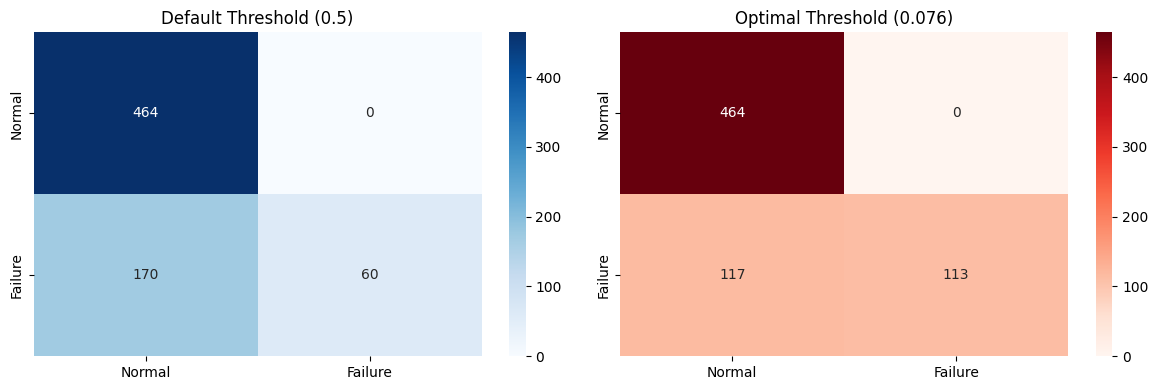

✅ Saved: optimized_detector_class_weights_only.keras

🧪 TESTING CONFIGURATION: FOCAL LOSS ONLY

🎯 Using FOCAL LOSS (alpha=0.75, gamma=2.0)
   This will focus learning on hard examples and minority class

🏋️ Training Focal Loss Only model...

🏋️ Training WITHOUT class weights
Epoch 1/25


/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7221 - loss: 0.1093 - val_accuracy: 0.7470 - val_loss: 0.0697 - learning_rate: 0.0010
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8807 - loss: 0.0266 - val_accuracy: 0.9482 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9227 - loss: 0.0190 - val_accuracy: 0.8841 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9454 - loss: 0.0142 - val_accuracy: 0.7774 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9609 - loss: 0.0097 - val_accuracy: 0.8293 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9676 - loss: 0.0089 - val_accuracy: 0.7774 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9830 - loss: 0.0053 - val_accuracy: 0.82

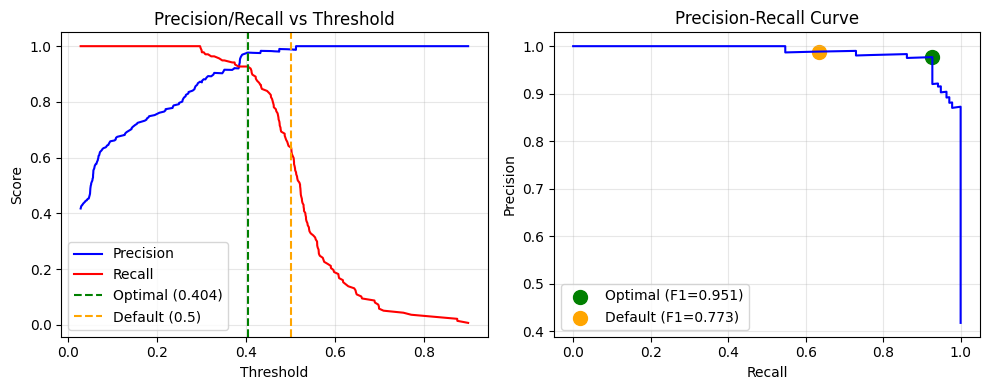


📊 EVALUATION WITH OPTIMAL THRESHOLD

🔄 COMPARISON: Default vs Optimal Threshold
--------------------------------------------------
Default (0.5):     Acc=0.795, Prec=1.000, Rec=0.383, F1=0.553
Optimal (0.404): Acc=0.814, Prec=0.990, Rec=0.443, F1=0.613

📈 IMPROVEMENTS:
   Accuracy:  +0.019
   Precision: -0.010
   Recall:    +0.061 ⭐
   F1-Score:  +0.059
   AUC:       0.965 (unchanged - depends on ranking)


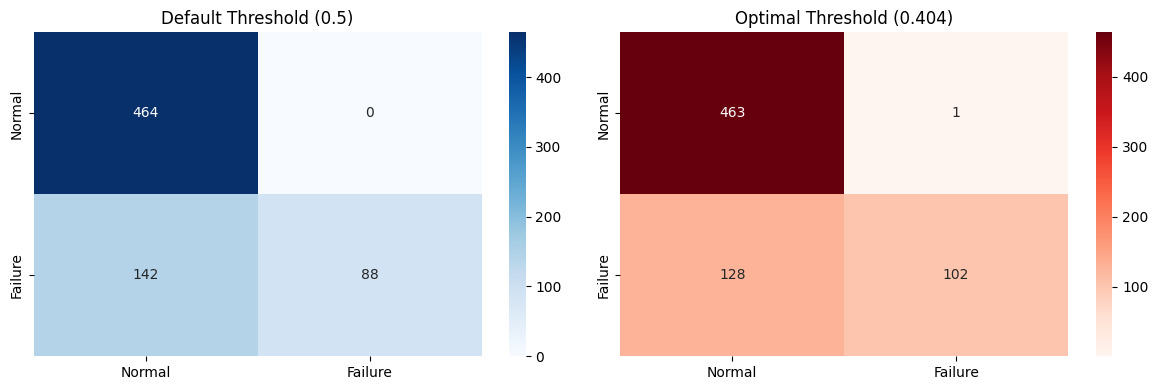

✅ Saved: optimized_detector_focal_loss_only.keras

🧪 TESTING CONFIGURATION: FULL OPTIMIZATION

🎯 Using FOCAL LOSS (alpha=0.75, gamma=2.0)
   This will focus learning on hard examples and minority class

🏋️ Training Full Optimization model...

⚖️  CLASS WEIGHTS CALCULATED:
   Normal: 0.726
   Failure: 1.607
   Failure examples are weighted 2.2x more than normal
   This compensates for class imbalance

🏋️ Training with CLASS WEIGHTS
Epoch 1/25


/home/alessandro/PGFDS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6827 - loss: 0.0580 - val_accuracy: 0.6890 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9630 - loss: 0.0149 - val_accuracy: 0.8902 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9811 - loss: 0.0067 - val_accuracy: 0.8902 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9773 - loss: 0.0074 - val_accuracy: 0.8933 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9659 - loss: 0.0067 - val_accuracy: 0.9238 - val_loss: 0.0217 - learning_rate: 0.0010
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9808 - loss: 0.0065 - val_accuracy: 0.9055 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9882 - loss: 0.0032 - val_accuracy: 0.90

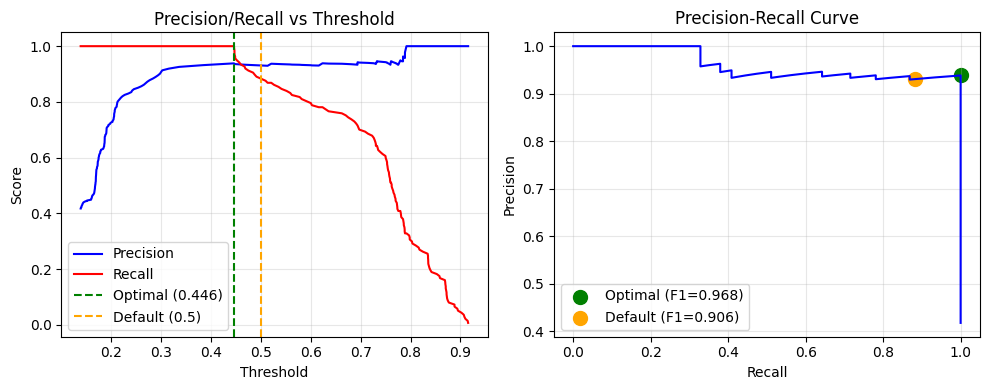


📊 EVALUATION WITH OPTIMAL THRESHOLD

🔄 COMPARISON: Default vs Optimal Threshold
--------------------------------------------------
Default (0.5):     Acc=0.807, Prec=0.990, Rec=0.422, F1=0.591
Optimal (0.446): Acc=0.805, Prec=0.970, Rec=0.426, F1=0.592

📈 IMPROVEMENTS:
   Accuracy:  -0.001
   Precision: -0.019
   Recall:    +0.004 ⭐
   F1-Score:  +0.001
   AUC:       0.944 (unchanged - depends on ranking)


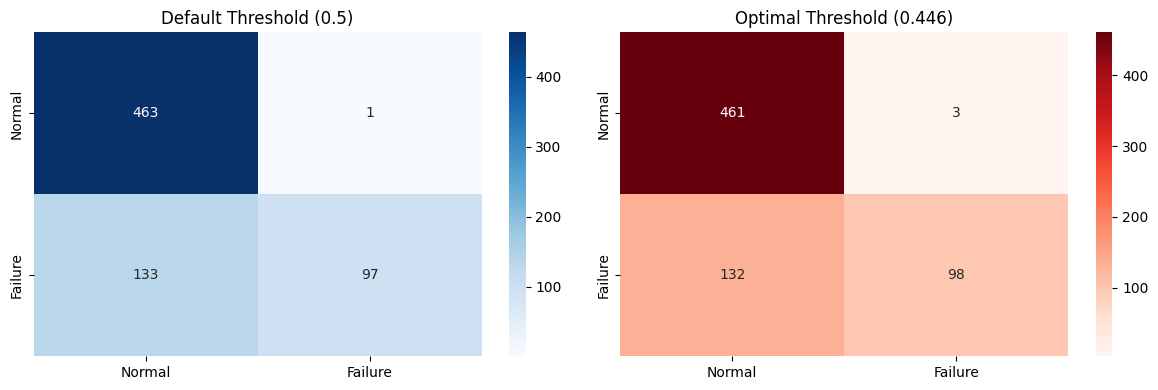

✅ Saved: optimized_detector_full_optimization.keras

🏆 FINAL COMPARISON OF ALL CONFIGURATIONS
                    accuracy  precision  recall     f1  threshold
Baseline               0.793      0.989   0.378  0.547      0.507
Class Weights Only     0.831      1.000   0.491  0.659      0.076
Focal Loss Only        0.814      0.990   0.443  0.613      0.404
Full Optimization      0.805      0.970   0.426  0.592      0.446

🥇 BEST CONFIGURATION: Class Weights Only
   F1-Score: 0.659
   Recall: 0.491
   Precision: 1.000


In [ ]:

# Set working directory
os.chdir('/home/alessandro/PGFDS/results/tuna/customers')

class OptimizedFailureDetector:
    """
    Detector ottimizzato con:
    1. Soglia ottimale automatica
    2. Bilanciamento classi
    3. Focal Loss per imbalanced data
    """
    
    def __init__(self, sequence_length=20, lstm_units=64, dropout_rate=0.3, 
                 use_focal_loss=True, use_class_weights=True):
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.scaler = StandardScaler()
        self.model = None
        
        # Configurazioni ottimizzazione
        self.use_focal_loss = use_focal_loss
        self.use_class_weights = use_class_weights
        
        # Finestre adattive
        self.failure_start_percent = 0.2
        self.failure_end_percent = 0.6
        
        # Soglia ottimale (sarà calcolata automaticamente)
        self.optimal_threshold = 0.5
        
    def focal_loss(self, alpha=0.75, gamma=2.0):
        """
        FOCAL LOSS - Spiegazione dettagliata:
        
        Il problema principale è che abbiamo molti più esempi "normali" che "failure".
        Durante il training, il modello si "abitua" a predire sempre "normale" perché
        è statisticamente più probabile avere ragione.
        
        La Focal Loss risolve questo in 2 modi:
        
        1. ALPHA WEIGHTING:
           - alpha=0.75 significa che i failure (classe minority) hanno peso 3x maggiore
           - I failure "costano" di più quando sbagliati
           - Il modello è "forzato" a prestare più attenzione ai failure
        
        2. GAMMA FOCUSING:
           - gamma=2.0 riduce il peso degli esempi "facili"
           - Se il modello è già sicuro al 95%, non impara molto
           - Concentra l'apprendimento sugli esempi difficili/ambigui
        
        Matematicamente:
        FL(p_t) = -alpha * (1-p_t)^gamma * log(p_t)
        
        Dove p_t è la probabilità corretta per la classe vera.
        """
        def focal_loss_fixed(y_true, y_pred):
            # Evita log(0) che darebbe infinito
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
            
            # p_t = probabilità della classe corretta
            # Se y_true=1 (failure), p_t=y_pred
            # Se y_true=0 (normal), p_t=1-y_pred
            p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
            
            # Alpha weighting: più peso alla classe minority (failure)
            alpha_factor = tf.ones_like(y_true) * alpha
            alpha_t = tf.where(tf.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
            
            # Standard cross entropy
            cross_entropy = -tf.math.log(p_t)
            
            # Focusing term: (1-p_t)^gamma
            # Se p_t è alto (esempio facile), il peso è basso
            # Se p_t è basso (esempio difficile), il peso è alto
            weight = alpha_t * tf.pow((1 - p_t), gamma)
            
            # Loss finale
            loss = weight * cross_entropy
            return tf.reduce_mean(loss)
        
        return focal_loss_fixed
    
    def load_and_label_data(self, unified_dir="unified"):
        """
        Carica dati con finestra failure adattiva
        """
        all_data = []
        
        print("📊 Loading data with adaptive failure windows...")
        
        for exp_dir in os.listdir(unified_dir):
            if not os.path.isdir(os.path.join(unified_dir, exp_dir)):
                continue
                
            csv_file = os.path.join(unified_dir, exp_dir, f"all_metrics_combined_{exp_dir}.csv")
            
            if os.path.exists(csv_file):
                print(f"Loading {exp_dir}...")
                df = pd.read_csv(csv_file)
                
                # Gestione time/minutes
                if 'time' in df.columns:
                    df['minutes'] = pd.to_numeric(df['time'], errors='coerce')
                    if df['minutes'].isna().any():
                        df['minutes'] = np.arange(len(df))
                    df = df.drop(columns=['time'])
                else:
                    df['minutes'] = np.arange(len(df))
                
                duration = df['minutes'].max() - df['minutes'].min()
                
                # Labeling adattivo
                if exp_dir == 'baseline':
                    df['is_failure'] = 0
                    print(f"  Baseline: all normal")
                else:
                    failure_start = df['minutes'].min() + (duration * self.failure_start_percent)
                    failure_end = df['minutes'].min() + (duration * self.failure_end_percent)
                    
                    df['is_failure'] = ((df['minutes'] >= failure_start) & 
                                       (df['minutes'] <= failure_end)).astype(int)
                    
                    failure_count = df['is_failure'].sum()
                    print(f"  {exp_dir}: {failure_count}/{len(df)} failures ({failure_count/len(df)*100:.1f}%)")
                
                df['experiment'] = exp_dir
                all_data.append(df)
        
        return pd.concat(all_data, ignore_index=True)
    
    def prepare_features(self, df):
        """
        Prepara features escludendo colonne temporali
        """
        feature_columns = df.select_dtypes(include=[np.number]).columns
        feature_columns = [col for col in feature_columns 
                          if col not in ['minutes', 'time', 'is_failure', 'Timestamp', 'timestamp']]
        
        print(f"Using {len(feature_columns)} features")
        return df[feature_columns].fillna(0).values, feature_columns
    
    def create_sequences(self, X, y, experiments):
        """
        Crea sequenze temporali per esperimento
        """
        X_sequences = []
        y_sequences = []
        experiment_info = []
        
        for exp_name in set(experiments):
            exp_mask = experiments == exp_name
            X_exp = X[exp_mask]
            y_exp = y[exp_mask]
            
            for i in range(len(X_exp) - self.sequence_length + 1):
                sequence = X_exp[i:i + self.sequence_length]
                label = y_exp[i + self.sequence_length - 1]
                
                X_sequences.append(sequence)
                y_sequences.append(label)
                experiment_info.append(exp_name)
        
        return np.array(X_sequences), np.array(y_sequences), experiment_info
    
    def calculate_class_weights(self, y_train):
        """
        CLASS WEIGHTS - Spiegazione dettagliata:
        
        Il problema: Se hai 1000 esempi "normali" e 100 esempi "failure",
        il modello impara che "predire sempre normale" gli dà 90% accuracy.
        
        La soluzione: Dare peso maggiore alla classe minority.
        
        Calcolo automatico:
        - Se hai 90% normali e 10% failure
        - Peso normale = 1 / (2 * 0.9) = 0.56
        - Peso failure = 1 / (2 * 0.1) = 5.0
        
        Risultato: Un errore su failure "costa" 9x di più che un errore su normale.
        Il modello è incentivato a non ignorare i failure.
        """
        # Calcola pesi bilanciati automaticamente
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        
        class_weight_dict = {}
        for i, cls in enumerate(classes):
            class_weight_dict[cls] = class_weights[i]
        
        print(f"\n⚖️  CLASS WEIGHTS CALCULATED:")
        for cls, weight in class_weight_dict.items():
            class_name = "Normal" if cls == 0 else "Failure"
            print(f"   {class_name}: {weight:.3f}")
        
        failure_weight = class_weight_dict.get(1, 1.0)
        normal_weight = class_weight_dict.get(0, 1.0)
        ratio = failure_weight / normal_weight
        
        print(f"   Failure examples are weighted {ratio:.1f}x more than normal")
        print(f"   This compensates for class imbalance")
        
        return class_weight_dict
    
    def build_optimized_model(self, input_shape):
        """
        Costruisce modello con focal loss o binary crossentropy
        """
        model = Sequential([
            LSTM(self.lstm_units, return_sequences=True, input_shape=input_shape),
            BatchNormalization(),
            Dropout(self.dropout_rate),
            
            LSTM(self.lstm_units // 2, return_sequences=False),
            BatchNormalization(),
            Dropout(self.dropout_rate),
            
            Dense(32, activation='relu'),
            Dropout(self.dropout_rate / 2),
            
            Dense(16, activation='relu'),
            
            Dense(1, activation='sigmoid')
        ])
        
        # Scelta della loss function
        if self.use_focal_loss:
            print(f"\n🎯 Using FOCAL LOSS (alpha=0.75, gamma=2.0)")
            print(f"   This will focus learning on hard examples and minority class")
            loss_function = self.focal_loss(alpha=0.75, gamma=2.0)
        else:
            print(f"\n📊 Using standard BINARY CROSSENTROPY")
            loss_function = 'binary_crossentropy'
        
        model.compile(
            optimizer='adam',
            loss=loss_function,
            metrics=['accuracy']
        )
        
        self.model = model
        return model
    
    def train_optimized_model(self, X_train, y_train, X_val, y_val, epochs=30):
        """
        Training con class weights opzionali
        """
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        # Calcola class weights se richiesto
        if self.use_class_weights:
            class_weight_dict = self.calculate_class_weights(y_train)
            print(f"\n🏋️ Training with CLASS WEIGHTS")
        else:
            class_weight_dict = None
            print(f"\n🏋️ Training WITHOUT class weights")
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            class_weight=class_weight_dict,  # Qui viene applicato il bilanciamento
            verbose=1
        )
        
        return history
    
    def find_optimal_threshold(self, X_val, y_val):
        """
        OPTIMAL THRESHOLD - Spiegazione dettagliata:
        
        Il problema: La soglia di default 0.5 è arbitraria.
        Non considera il costo relativo dei diversi tipi di errore.
        
        La soluzione: Trova la soglia che ottimizza il trade-off precision/recall.
        
        Processo:
        1. Calcola precision/recall per tutte le soglie possibili (0.0 to 1.0)
        2. Per ogni soglia, calcola F1-score = 2 * (precision * recall) / (precision + recall)
        3. Scegli la soglia che massimizza F1-score
        
        Perché F1? Bilancia precision e recall:
        - Precision alta = pochi falsi allarmi
        - Recall alto = pochi failure mancati
        - F1 alto = buon compromesso tra entrambi
        
        Alternative:
        - Se i falsi allarmi costano molto: ottimizza precision
        - Se i failure mancati costano molto: ottimizza recall
        - Per sistemi critici: spesso si preferisce recall alto
        """
        print(f"\n🔍 FINDING OPTIMAL THRESHOLD...")
        
        # Ottieni probabilità su validation set
        y_pred_proba = self.model.predict(X_val, verbose=0).flatten()
        
        # Calcola precision/recall per tutte le soglie
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
        
        # Calcola F1-score per ogni soglia
        # Evita divisione per zero
        f1_scores = []
        for p, r in zip(precision, recall):
            if p + r == 0:
                f1_scores.append(0)
            else:
                f1_scores.append(2 * (p * r) / (p + r))
        
        f1_scores = np.array(f1_scores)
        
        # Trova soglia ottimale
        optimal_idx = np.argmax(f1_scores)
        self.optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        optimal_f1 = f1_scores[optimal_idx]
        optimal_precision = precision[optimal_idx]
        optimal_recall = recall[optimal_idx]
        
        print(f"   Default threshold (0.5):")
        default_predictions = (y_pred_proba > 0.5).astype(int)
        default_precision = np.sum((default_predictions == 1) & (y_val == 1)) / max(np.sum(default_predictions == 1), 1)
        default_recall = np.sum((default_predictions == 1) & (y_val == 1)) / max(np.sum(y_val == 1), 1)
        default_f1 = 2 * (default_precision * default_recall) / max(default_precision + default_recall, 1e-8)
        
        print(f"     Precision: {default_precision:.3f}, Recall: {default_recall:.3f}, F1: {default_f1:.3f}")
        
        print(f"   Optimal threshold ({self.optimal_threshold:.3f}):")
        print(f"     Precision: {optimal_precision:.3f}, Recall: {optimal_recall:.3f}, F1: {optimal_f1:.3f}")
        
        improvement = ((optimal_f1 - default_f1) / default_f1 * 100) if default_f1 > 0 else 0
        print(f"   Improvement: {improvement:+.1f}% F1-score")
        
        # Plot precision-recall curve
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
        plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
        plt.axvline(self.optimal_threshold, color='green', linestyle='--', label=f'Optimal ({self.optimal_threshold:.3f})')
        plt.axvline(0.5, color='orange', linestyle='--', label='Default (0.5)')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Precision/Recall vs Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, 'b-')
        plt.scatter(optimal_recall, optimal_precision, color='green', s=100, 
                   label=f'Optimal (F1={optimal_f1:.3f})')
        plt.scatter(default_recall, default_precision, color='orange', s=100,
                   label=f'Default (F1={default_f1:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return self.optimal_threshold
    
    def evaluate_with_optimal_threshold(self, X_test, y_test):
        """
        Valutazione usando soglia ottimale
        """
        print(f"\n📊 EVALUATION WITH OPTIMAL THRESHOLD")
        print("="*60)
        
        # Predizioni con soglia ottimale
        y_pred_proba = self.model.predict(X_test, verbose=0).flatten()
        y_pred_optimal = (y_pred_proba > self.optimal_threshold).astype(int)
        y_pred_default = (y_pred_proba > 0.5).astype(int)
        
        # Calcola metriche per entrambe le soglie
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        print(f"\n🔄 COMPARISON: Default vs Optimal Threshold")
        print("-" * 50)
        
        # Default threshold (0.5)
        acc_default = accuracy_score(y_test, y_pred_default)
        prec_default = precision_score(y_test, y_pred_default, zero_division=0)
        rec_default = recall_score(y_test, y_pred_default, zero_division=0)
        f1_default = f1_score(y_test, y_pred_default, zero_division=0)
        
        print(f"Default (0.5):     Acc={acc_default:.3f}, Prec={prec_default:.3f}, Rec={rec_default:.3f}, F1={f1_default:.3f}")
        
        # Optimal threshold
        acc_optimal = accuracy_score(y_test, y_pred_optimal)
        prec_optimal = precision_score(y_test, y_pred_optimal, zero_division=0)
        rec_optimal = recall_score(y_test, y_pred_optimal, zero_division=0)
        f1_optimal = f1_score(y_test, y_pred_optimal, zero_division=0)
        
        print(f"Optimal ({self.optimal_threshold:.3f}): Acc={acc_optimal:.3f}, Prec={prec_optimal:.3f}, Rec={rec_optimal:.3f}, F1={f1_optimal:.3f}")
        
        # Calcola miglioramenti
        print(f"\n📈 IMPROVEMENTS:")
        print(f"   Accuracy:  {acc_optimal - acc_default:+.3f}")
        print(f"   Precision: {prec_optimal - prec_default:+.3f}")
        print(f"   Recall:    {rec_optimal - rec_default:+.3f} ⭐")
        print(f"   F1-Score:  {f1_optimal - f1_default:+.3f}")
        
        # AUC
        if len(np.unique(y_test)) > 1:
            auc_score = roc_auc_score(y_test, y_pred_proba)
            print(f"   AUC:       {auc_score:.3f} (unchanged - depends on ranking)")
        
        # Confusion matrices
        cm_default = confusion_matrix(y_test, y_pred_default)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Failure'],
                   yticklabels=['Normal', 'Failure'])
        plt.title('Default Threshold (0.5)')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Reds',
                   xticklabels=['Normal', 'Failure'],
                   yticklabels=['Normal', 'Failure'])
        plt.title(f'Optimal Threshold ({self.optimal_threshold:.3f})')
        
        plt.tight_layout()
        plt.show()
        
        return acc_optimal, prec_optimal, rec_optimal, f1_optimal

def create_failure_aware_split(X_seq, y_seq, exp_info, test_ratio=0.3):
    """
    Split che garantisce failure nel test set
    """
    train_indices = []
    test_indices = []
    
    for exp in set(exp_info):
        exp_mask = np.array(exp_info) == exp
        exp_indices = np.where(exp_mask)[0]
        exp_labels = y_seq[exp_indices]
        
        failure_indices = exp_indices[exp_labels == 1]
        normal_indices = exp_indices[exp_labels == 0]
        
        if len(failure_indices) > 0:
            # Mantieni failure in entrambi train e test
            n_failure_test = max(1, int(len(failure_indices) * test_ratio))
            failure_test = failure_indices[-n_failure_test:]
            failure_train = failure_indices[:-n_failure_test]
            
            n_normal_test = int(len(normal_indices) * test_ratio)
            normal_test = normal_indices[-n_normal_test:]
            normal_train = normal_indices[:-n_normal_test]
            
            train_indices.extend(failure_train)
            train_indices.extend(normal_train)
            test_indices.extend(failure_test)
            test_indices.extend(normal_test)
        else:
            # Solo normale (baseline)
            n_test = int(len(exp_indices) * test_ratio)
            test_indices.extend(exp_indices[-n_test:])
            train_indices.extend(exp_indices[:-n_test])
    
    return train_indices, test_indices

def main_optimized():
    """
    Training completo con tutte le ottimizzazioni
    """
    print("=== OPTIMIZED FAILURE DETECTION TRAINING ===\n")
    
    # Testa diverse configurazioni
    configurations = [
        {"name": "Baseline", "focal_loss": False, "class_weights": False},
        {"name": "Class Weights Only", "focal_loss": False, "class_weights": True},
        {"name": "Focal Loss Only", "focal_loss": True, "class_weights": False},
        {"name": "Full Optimization", "focal_loss": True, "class_weights": True},
    ]
    
    results = {}
    
    for config in configurations:
        print(f"\n{'='*80}")
        print(f"🧪 TESTING CONFIGURATION: {config['name'].upper()}")
        print(f"{'='*80}")
        
        # Inizializza detector con configurazione
        detector = OptimizedFailureDetector(
            sequence_length=20, 
            lstm_units=64,
            use_focal_loss=config['focal_loss'],
            use_class_weights=config['class_weights']
        )
        
        # Carica e prepara dati (solo una volta)
        if 'df' not in locals():
            df = detector.load_and_label_data("unified")
            X, feature_columns = detector.prepare_features(df)
            y = df['is_failure'].values
            experiments = df['experiment'].values
            
            X_scaled = detector.scaler.fit_transform(X)
            X_seq, y_seq, exp_info = detector.create_sequences(X_scaled, y, experiments)
            
            # Split
            train_idx, test_idx = create_failure_aware_split(X_seq, y_seq, exp_info)
            X_train = X_seq[train_idx]
            y_train = y_seq[train_idx]
            X_test = X_seq[test_idx]
            y_test = y_seq[test_idx]
            
            # Validation split
            val_split = int(len(X_train) * 0.8)
            X_train_final = X_train[:val_split]
            y_train_final = y_train[:val_split]
            X_val = X_train[val_split:]
            y_val = y_train[val_split:]
            
            print(f"\nDataset: {len(X_seq)} sequences, {y_seq.sum()} failures")
            print(f"Splits: Train={len(X_train_final)}, Val={len(X_val)}, Test={len(X_test)}")
        
        # Costruisci e addestra modello
        model = detector.build_optimized_model((X_seq.shape[1], X_seq.shape[2]))
        
        print(f"\n🏋️ Training {config['name']} model...")
        history = detector.train_optimized_model(
            X_train_final, y_train_final, 
            X_val, y_val, 
            epochs=25
        )
        
        # Trova soglia ottimale
        optimal_threshold = detector.find_optimal_threshold(X_val, y_val)
        
        # Valuta con soglia ottimale
        acc, prec, rec, f1 = detector.evaluate_with_optimal_threshold(X_test, y_test)
        
        # Salva risultati
        results[config['name']] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'threshold': optimal_threshold
        }
        
        # Salva modello
        model_name = f"optimized_detector_{config['name'].lower().replace(' ', '_')}.keras"
        detector.model.save(model_name)
        print(f"✅ Saved: {model_name}")
    
    # Confronto finale
    print(f"\n{'='*80}")
    print(f"🏆 FINAL COMPARISON OF ALL CONFIGURATIONS")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame(results).T
    print(comparison_df.round(3))
    
    # Trova migliore configurazione
    best_config = comparison_df['f1'].idxmax()
    best_f1 = comparison_df['f1'].max()
    
    print(f"\n🥇 BEST CONFIGURATION: {best_config}")
    print(f"   F1-Score: {best_f1:.3f}")
    print(f"   Recall: {comparison_df.loc[best_config, 'recall']:.3f}")
    print(f"   Precision: {comparison_df.loc[best_config, 'precision']:.3f}")
    
    return results, detector

# Esegui training ottimizzato
print("Starting optimized training with all techniques...")
results, best_detector = main_optimized()